In [57]:
import re
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import emoji
import itertools 
from collections import Counter
import warnings
import random

%matplotlib inline
warnings.filterwarnings('ignore')

In [58]:
# Using data exported from a Whatsapp group throug my cell/mobile phone
# Exported the chat, and shared with myself via email. It comes as a .txt file
# Unable to export the chat via the Whatsapp web version at this moment

chat_file = open("C:\\Users\\oriordanro\\Downloads\\WhatsApp Chat with lads.txt", encoding="utf-8")

In [59]:
# Creating functions to deal with the .txt file

def date_time(s):
    pattern = '^([0-9]+)(\/)([0-9]+)(\/)([0-9]+), ([0-9]+):([0-9]+)[ ]?(AM|PM|am|pm)? -'
    result = re.match(pattern, s)
    if result:
        return True
    return False

def find_author(s):
    s = s.split(":")
    if len(s)==2:
        return True
    else:
        return False

def getDatapoint(line):
    splitline = line.split(' - ')
    dateTime = splitline[0]
    date, time = dateTime.split(", ")
    message = " ".join(splitline[1:])
    if find_author(message):
        splitmessage = message.split(": ")
        author = splitmessage[0]
        message = " ".join(splitmessage[1:])
    else:
        author= None
    return date, time, author, message

In [60]:
data = []
conversation = "C:\\Users\\oriordanro\\Downloads\\WhatsApp Chat with lads.txt"
with open(conversation, encoding="utf-8") as fp:
    fp.readline()
    messageBuffer = []
    date, time, author = None, None, None
    while True:
        line = fp.readline()
        if not line:
            break
        line = line.strip()
        if date_time(line):
            if len(messageBuffer) > 0:
                data.append([date, time, author, ' '.join(messageBuffer)])
            messageBuffer.clear()
            date, time, author, message = getDatapoint(line)
            messageBuffer.append(message)
        else:
            messageBuffer.append(line)

In [61]:
# Converting the message text to lower
# Adding different date groups

df = pd.DataFrame(data, columns=["Date", 'Time', 'Sender', 'Message'])
df["Timestamp"] = pd.to_datetime(df["Date"] + ' ' + df["Time"])
df['Date'] = pd.to_datetime(df['Date'])
df['Message'] = df['Message'].astype(str).str.lower()
df['hour'] = df['Timestamp'].dt.strftime('%H:00')
df['day'] = df['Date'].dt.strftime('%a')
df['month'] = df['Date'].dt.strftime('%b')
df['year'] = df['Date'].dt.year
df['date'] = df['Date'].apply(lambda x: x.date())

In [62]:
# Removing sender name and replacing them with random int

sender_list = [i for i in df['Sender'].unique()]
sender_list = pd.DataFrame(sender_list, columns = ['Sender'])
sender_list.sort_values(by = 'Sender', inplace = True)
sender_list.reset_index(inplace = True)
sender_list.drop(['index'], axis = 1, inplace = True)
sender_list['sender_randint'] = [ random.randint(1,1000) for i in sender_list.index]

df = df.merge(sender_list, how='left', on = 'Sender')
df.drop('Sender', axis = 1, inplace = True)

# Using a copy of the original data frame
df1 = df.copy()  
df1.head()

,Date,Time,Message,Timestamp,hour,day,month,year,date,sender_randint
0,2022-10-15,22:49,"king 🇺🇸 created group ""bse""",2022-10-15 22:49:00,22:00,Sat,Oct,2022,2022-10-15,846
1,2022-10-16,11:24,paul added you,2022-10-16 11:24:00,11:00,Sun,Oct,2022,2022-10-16,846
2,2022-10-16,11:26,you're now an admin,2022-10-16 11:26:00,11:00,Sun,Oct,2022,2022-10-16,846
3,2022-10-16,13:38,"now king, are you happy now ?",2022-10-16 13:38:00,13:00,Sun,Oct,2022,2022-10-16,826
4,2022-10-16,13:38,king's shares in meta 📈🚀,2022-10-16 13:38:00,13:00,Sun,Oct,2022,2022-10-16,826


# Sentiment Analysis

## NLTK (VADER)

In [63]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist

In [64]:
nltk.download([
     "names",
     "stopwords",
     "state_union",
     "twitter_samples",
     "movie_reviews",
     "averaged_perceptron_tagger",
     "vader_lexicon",
     "punkt",])

[nltk_data] Downloading package names to
[nltk_data]     C:\Users\oriordanro\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\oriordanro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package state_union to
[nltk_data]     C:\Users\oriordanro\AppData\Roaming\nltk_data...
[nltk_data]   Package state_union is already up-to-date!
[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\oriordanro\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\oriordanro\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\oriordanro\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_p

True

In [65]:
# Removing unnecessary words

removed_list = ["the", "jpg" , "file", "attached", "img", "WA0000", "mp4", "VID", "Media", "omitted"
                 , "omitted>", "<media", ",", ".", "ya", "ye", "?", "yeah", "https", "s"] + list(STOPWORDS)

stopwords = removed_list + nltk.corpus.stopwords.words("english")

In [66]:
# removing media omitted

df2_messages = pd.DataFrame(df1)
df2_messages = df2_messages[df2_messages["Message"] != "<media omitted>"] 

In [67]:
regexp = RegexpTokenizer('\w+')

df2_messages['text_token']=df2_messages["Message"].apply(regexp.tokenize)

In [68]:
# removing stop words
df2_messages['text_token'] = df2_messages['text_token'].apply(lambda x: [item for item in x if item not in removed_list])

# removing infrequent words
df2_messages['text_string'] = df2_messages['text_token'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))

In [69]:
# create a list of all words
all_words = ' '.join([word for word in df2_messages['text_string']])

# Tokenize all_words
tokenized_words = nltk.tokenize.word_tokenize(all_words)

In [70]:
fdist = FreqDist(tokenized_words)
fdist

FreqDist({'haha': 40, 'man': 26, 'now': 25, 'king': 22, 'fossa': 21, 'damo': 19, 'going': 17, 'well': 17, 'back': 17, 'group': 16, ...})

In [71]:
df2_messages['text_string_fdist'] = df2_messages['text_token'].apply(lambda x: ' '.join([item for item in x if fdist[item] >= 1 ]))

In [72]:
from nltk.stem import WordNetLemmatizer

In [73]:
wordnet_lem = WordNetLemmatizer()

df2_messages['text_string_lem'] = df2_messages['text_string_fdist'].apply(wordnet_lem.lemmatize)

In [74]:
df2_messages['is_equal']= (df2_messages['text_string_fdist']==df2_messages['text_string_lem'])
df2_messages.is_equal.value_counts()

True     694
False      3
Name: is_equal, dtype: int64

In [75]:
all_words_lem = ' '.join([word for word in df2_messages['text_string_lem']])

In [76]:
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.sentiment import SentimentIntensityAnalyzer

In [77]:
analyzer = SentimentIntensityAnalyzer()

In [78]:
# Polarity scores
df2_messages['polarity'] = df2_messages['text_string_lem'].apply(lambda x: analyzer.polarity_scores(x))

In [79]:
df2_messages = pd.concat(
    [df2_messages
     ,df2_messages['polarity'].apply(pd.Series)], axis=1)

In [80]:
# Create new variable with sentiment "neutral," "positive" and "negative"
df2_messages['sentiment'] = df2_messages['compound'].apply(lambda x: 'positive' if x >0 else 'neutral' if x==0 else 'negative')
df2_messages.head(4)

,Date,Time,Message,Timestamp,hour,day,month,year,date,sender_randint,...,text_string,text_string_fdist,text_string_lem,is_equal,polarity,neg,neu,pos,compound,sentiment
0,2022-10-15,22:49,"king 🇺🇸 created group ""bse""",2022-10-15 22:49:00,22:00,Sat,Oct,2022,2022-10-15,846,...,king created group bse,king created group bse,king created group bse,True,"{'neg': 0.0, 'neu': 0.6, 'pos': 0.4, 'compound...",0.0,0.600,0.400,0.2500,positive
1,2022-10-16,11:24,paul added you,2022-10-16 11:24:00,11:00,Sun,Oct,2022,2022-10-16,846,...,paul added,paul added,paul added,True,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,1.000,0.000,0.0000,neutral
2,2022-10-16,11:26,you're now an admin,2022-10-16 11:26:00,11:00,Sun,Oct,2022,2022-10-16,846,...,now admin,now admin,now admin,True,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,1.000,0.000,0.0000,neutral
3,2022-10-16,13:38,"now king, are you happy now ?",2022-10-16 13:38:00,13:00,Sun,Oct,2022,2022-10-16,826,...,now king happy now,now king happy now,now king happy now,True,"{'neg': 0.0, 'neu': 0.448, 'pos': 0.552, 'comp...",0.0,0.448,0.552,0.5719,positive


### Overall sentiment split

[Text(0, 0.5, ''),
 Text(0.5, 0, ''),
 Text(0.5, 1.0, 'Message Count by Sentiment')]

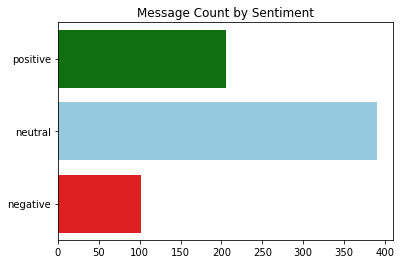

In [90]:
g = sns.countplot(y='sentiment', 
             data=df2_messages, 
             palette=['green','skyblue','red'])

g.set(ylabel= None
     ,xlabel = None
     ,title = 'Message Count by Sentiment'
     )

### Total compound by sender

Text(0.5, 1.0, 'Compound Total by Sender')

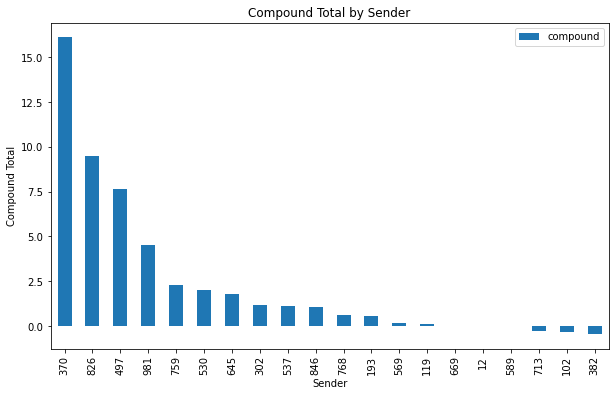

In [87]:
tot_comp_sender = pd.DataFrame(df2_messages.groupby("sender_randint").sum("compound")['compound'].sort_values(ascending = False))

# Total Compound Sender
tot_comp_sender.plot(kind = 'bar'
                    , stacked=True
                    , figsize = (10,6)
            )

plt.xlabel(xlabel = None)
plt.xticks(rotation=90, fontsize=10)
plt.ylabel('Compound Total')
plt.xlabel('Sender')
plt.title('Compound Total by Sender')

### Sentiment split by sender 

#### (i)

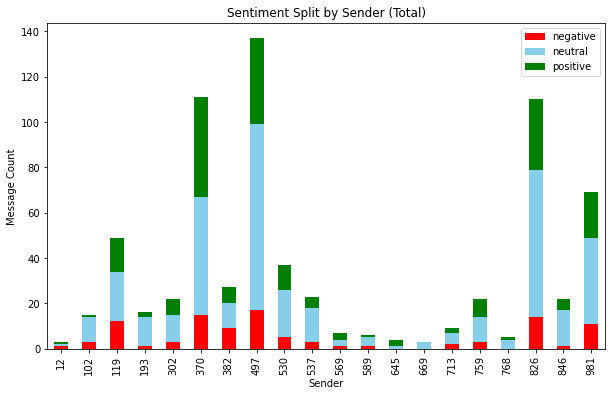

In [88]:
sentiment_count_sender = df2_messages.reset_index().groupby(["sender_randint","sentiment"]).count().sort_values(ascending = True,by=["sender_randint","sentiment","index",])["index"]

sentiment_count_sender.unstack().plot(kind='bar'
                    , stacked=True
                    , color=['red', 'skyblue', 'green']
                    , figsize = (10,6)
                    , title = 'Sentiment Split by Sender (Total)'
            )

plt.xlabel('Sender')
plt.ylabel('Message Count')
plt.legend(bbox_to_anchor=(1,1))

#### (ii)

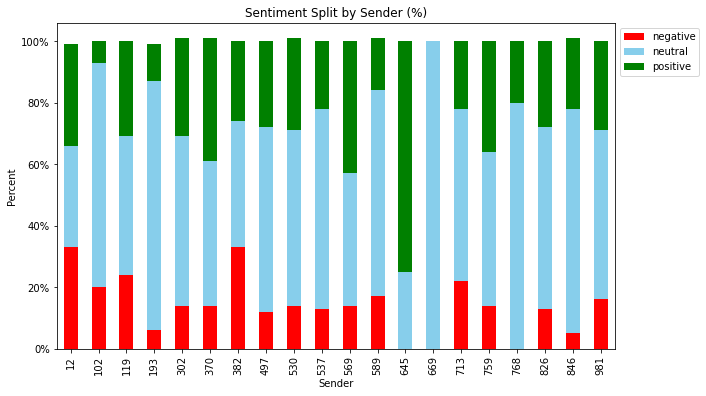

In [89]:
senetiment_split_perc = df2_messages.reset_index().groupby(["sender_randint","sentiment"]).count().sort_values(ascending = True,by=["sender_randint","sentiment","index",])["index"]
# test_2['total'] = test_2.groupby("Sender").sum()
senetiment_split_perc = pd.DataFrame(data = senetiment_split_perc, columns = ['index'])
senetiment_split_perc.rename(columns = {"index": "message_count"}, inplace = True)
senetiment_split_perc_2 = senetiment_split_perc.groupby('sender_randint').sum('message_count')
senetiment_split_perc_2 = senetiment_split_perc.merge(senetiment_split_perc_2, how = 'left', left_index = True, right_index = True)
senetiment_split_perc_2.rename(columns = {"message_count_x": "message_count"
                        ,"message_count_y": "total_messages"}, inplace = True)
senetiment_split_perc_2['%_of_total'] = round(senetiment_split_perc_2['message_count'] *1.0/ senetiment_split_perc_2['total_messages'],2)


senetiment_split_perc_2.unstack().plot(kind='bar'
                    ,stacked = True
                    , color=['red', 'skyblue', 'green']
                    , figsize = (10,6)
                    , y = "%_of_total"  
                    , title = "Sentiment Split by Sender (%)"
            )

plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
plt.ylabel('Percent')
plt.xlabel('Sender')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

#### Word cloud

In [ ]:
removed_list = ["the", "jpg" , "file", "attached", "img", "WA0000", "mp4", "VID", "Media", "omitted"
                 , "omitted>", "<media", ",", ".", "ya", "ye", "?", "yeah", "https", "s"] + list(STOPWORDS)

text = " ".join(review for review in df1.Message)
wordcloud = WordCloud(stopwords = removed_list
                      ,background_color="white"
                      ,max_words = 100
                      ,prefer_horizontal=1
                     ).generate(text)

  ### Display the generated image:
plt.figure( figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Flair

In [91]:
from flair.models import TextClassifier
from flair.data import Sentence
from datetime import datetime
import time

In [93]:
df3_messages = df1.copy()

df3_messages = pd.DataFrame(df2_messages)
df3_messages = df2_messages[df2_messages["Message"] != "<media omitted>"] # removing media omitted

In [94]:
df3_messages["word_count"] = df3_messages['Message'].str.split().str.len()
df3_messages['count'] = 1

In [95]:
def flair_prediction(x):
    sentence = Sentence(x)
    sia.predict(sentence)
    score = sentence.labels[0]
    if "POSITIVE" in str(score):
        return "pos"
    elif "NEGATIVE" in str(score):
        return "neg"
    else:
        return "neu"
    
def flair_prediction_value(x):
    sentence = Sentence(x)
    sia.predict(sentence)
    score = sentence.labels[0]
    return score.score

In [96]:
sia = TextClassifier.load('en-sentiment')
start = datetime.now()
df3_messages["sentiment"] = df3_messages['Message'].apply(flair_prediction)
end = datetime.now()
print(end - start)

2022-12-12 22:03:09,026 loading file C:\Users\oriordanro\.flair\models\sentiment-en-mix-distillbert_4.pt
0:00:28.491586


In [97]:
df3_messages["pred_value"] = df3_messages['Message'].apply(flair_prediction_value)

### Flair Visualizations

[Text(0.5, 0, ''),
 Text(0, 0.5, ''),
 Text(0.5, 1.0, 'Message Count by Sentiment')]

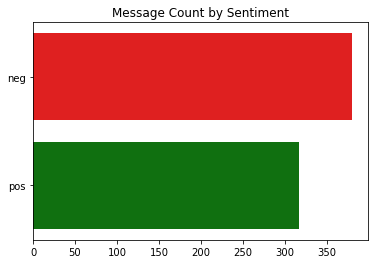

In [101]:
# Number of tweets 
g = sns.countplot(y='sentiment', 
             data=df3_messages, 
             palette=['red',"green"],
             )
g.set(xlabel = None
     ,ylabel = None
    ,title ='Message Count by Sentiment'
     )


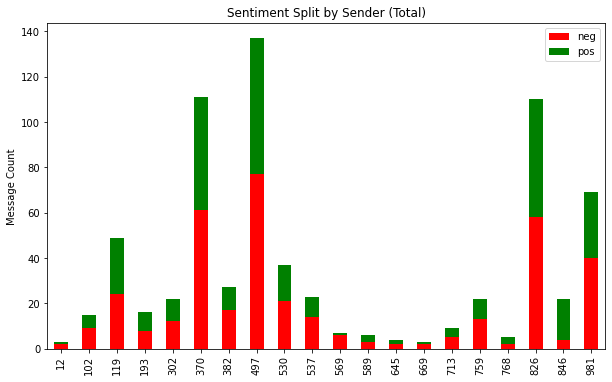

In [102]:
sent_count_sender_flair = df3_messages.reset_index().groupby(["sender_randint","sentiment"]).count().sort_values(ascending = True,by=["sender_randint","sentiment","index",])["index"]

sent_count_sender_flair.unstack().plot(kind='bar'
                    , stacked=True
                    , color=['red', 'green']
                    , figsize = (10,6)
                    , title = 'Sentiment Split by Sender (Total)'
            )

plt.xlabel('')
plt.ylabel('Message Count')
plt.legend(bbox_to_anchor=(1,1))

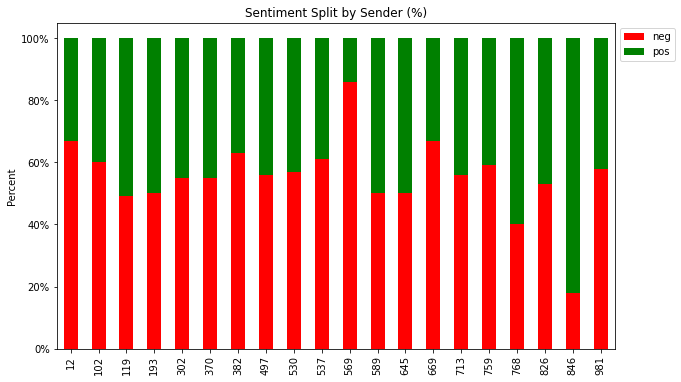

In [103]:
senetiment_split_perc_flair = df3_messages.reset_index().groupby(["sender_randint","sentiment"]).count().sort_values(ascending = True,by=["sender_randint","sentiment","index",])["index"]
# test_2['total'] = test_2.groupby("Sender").sum()
senetiment_split_perc_flair = pd.DataFrame(data = senetiment_split_perc_flair, columns = ['index'])
senetiment_split_perc_flair.rename(columns = {"index": "message_count"}, inplace = True)
senetiment_split_perc_2_flair = senetiment_split_perc_flair.groupby('sender_randint').sum('message_count')
senetiment_split_perc_2_flair = senetiment_split_perc_flair.merge(senetiment_split_perc_2_flair, how = 'left', left_index = True, right_index = True)
senetiment_split_perc_2_flair.rename(columns = {"message_count_x": "message_count"
                        ,"message_count_y": "total_messages"}, inplace = True)
senetiment_split_perc_2_flair['%_of_total'] = round(senetiment_split_perc_2_flair['message_count'] *1.0/ senetiment_split_perc_2_flair['total_messages'],2)
senetiment_split_perc_2_flair.head(3)

senetiment_split_perc_2_flair.unstack().plot(kind='bar'
                    ,stacked = True
                    , color=['red','green']
                    , figsize = (10,6)
                    , y = "%_of_total"  
                    , title = "Sentiment Split by Sender (%)"
            )

plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
plt.ylabel('Percent')
plt.xlabel(xlabel = None)
plt.legend(bbox_to_anchor=(1,1))
plt.show()

### Looking at messages with >80% Flair prediction value

In [104]:
print(len(df3_messages[df3_messages['pred_value'] > .80]))
print(len(df3_messages))

577
697


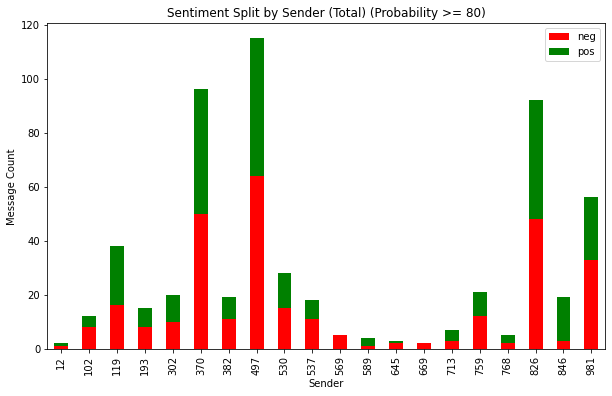

In [105]:
df3_messages_pred_80 = df3_messages[df3_messages['pred_value'] > .80]

sent_count_sender_flair_80 = df3_messages_pred_80.reset_index().groupby(["sender_randint","sentiment"]).count().sort_values(ascending = True,by=["sender_randint","sentiment","index",])["index"]

sentiment_split_perc_flair_80 = df3_messages_pred_80.reset_index().groupby(["sender_randint","sentiment"]).count().sort_values(ascending = True,by=["sender_randint","sentiment","index",])["index"]
# test_2['total'] = test_2.groupby("Sender").sum()
sentiment_split_perc_flair_80 = pd.DataFrame(data = sentiment_split_perc_flair_80, columns = ['index'])
sentiment_split_perc_flair_80.rename(columns = {"index": "message_count"}, inplace = True)
sentiment_split_perc_2_flair_80 = sentiment_split_perc_flair_80.groupby('sender_randint').sum('message_count')
sentiment_split_perc_2_flair_80 = sentiment_split_perc_flair_80.merge(sentiment_split_perc_2_flair_80, how = 'left', left_index = True, right_index = True)
sentiment_split_perc_2_flair_80.rename(columns = {"message_count_x": "message_count"
                        ,"message_count_y": "total_messages"}, inplace = True)
sentiment_split_perc_2_flair_80['%_of_total'] = round(sentiment_split_perc_2_flair_80['message_count'] *1.0/ sentiment_split_perc_2_flair_80['total_messages'],2)

sent_count_sender_flair_80.unstack().plot(kind='bar'
                    , stacked=True
                    , color=['red', 'green']
                    , figsize = (10,6)
                    , title = 'Sentiment Split by Sender (Total) (Probability >= 80)'
            )

plt.xlabel('Sender')
plt.ylabel('Message Count')
plt.legend(bbox_to_anchor=(1,1))

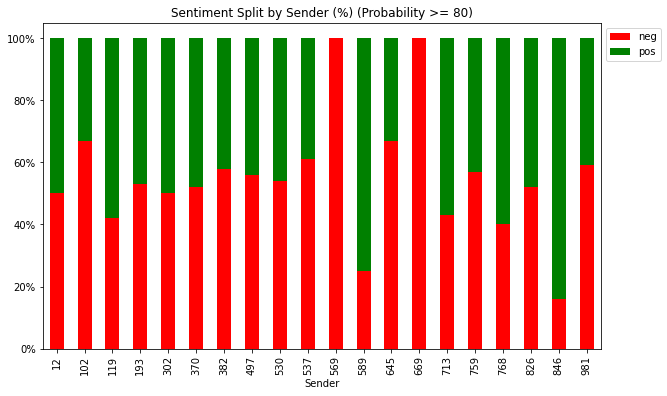

In [106]:
sentiment_split_perc_2_flair_80.unstack().plot(kind='bar'
                    ,stacked = True
                    , color=['red', 'green']
                    , figsize = (10,6)
                    , y = "%_of_total"  
                    , title = "Sentiment Split by Sender (%) (Probability >= 80)"
            )

plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
plt.ylabel(ylabel = None)
plt.xlabel(xlabel = 'Sender')
plt.legend(bbox_to_anchor=(1,1))
plt.show()